# Escola Politécnica da Universidade de São Paulo

<img src="http://www.imagens.usp.br/wp-content/uploads/EP.jpg" height="50" width="200">

## PMR 3508 - Aprendizado de Máquinas e Reconhecimento de Padrões

#### Autor: Lucas Penna Saraiva

### Tarefa 4: Fashion MNIST

#### Objetivos:

- (1) Faça uma exploração das bases de treino disponíveis para você (train_images_pure.npy, train_images_rotated.npy, train_images_noisy.npy, train_images_both.npy) Qual a diferença entre elas?


- (2) Implemente uma simples rede neural convolucional de classificação **sem usar Pooling**. Demonstre um método de seleção dos hiperparâmetros - tamanho do kernel, número de camadas, etc. Teste seu modelo usando a versão randomicamente rotacionada da base de treino (train_images_rotated.npy). Qual a performance resultante? Teste seu modelo finalmente na base de treino rotacionada e corrompida (train_images_both.npy). Qual a performance neste caso?


- (3) Implemente uma rede neural convolucional **com camadas de Pooling**. A performance do seu sistema melhorou? Se sim, qual a razão para isto? Teste seu modelo usando a versão rotacionada da base de treino (train_images_rotated.npy). Comparado ao modelo que não continha pooling, como foi a performance? Finalmente, teste seu modelo na base de treino rotacionada e corrompida (train_images_both.npy). Qual a performance resultante?


- (4) Existe algum tipo de pre-processamento que pode ser feito nestas imagens para auxiliar o classificador a se livrar da influência deste tipo de ruído? Qual? Teste suas hipóteses usando a base de treino (train_images_noisy.npy) - descreva suas conclusões. (https://towardsdatascience.com/image-pre-processing-c1aec0be3edf)


- (5) Responda a estas perguntas: O que é um "Single Pixel Attack" ? Porque ele ele é tão preocupante? O que podemos fazer para mitigar esta vulnerabilidade?


## 1. Exploração das bases de treino

In [1]:
%matplotlib inline

import numpy as np#arrays operations
import matplotlib.pyplot as plt # shows the image

### 1.1 Exploração do dataset de imagens "puras"

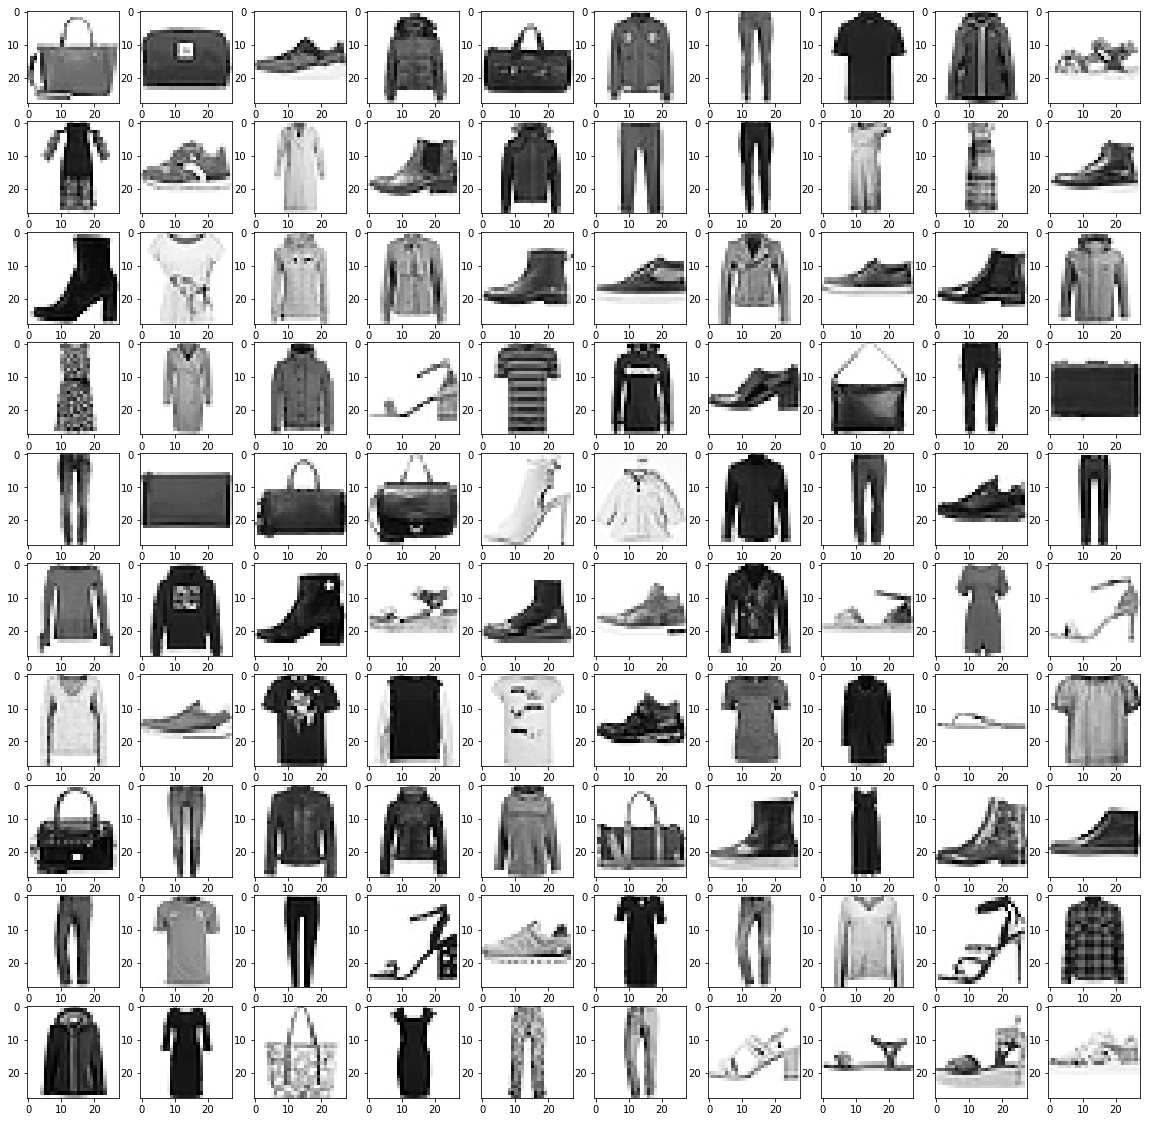

In [2]:
img_np1 = np.load("train_images_pure.npy", mmap_mode=None, allow_pickle=True, fix_imports=True)

fig=plt.figure(figsize=(20, 20))
columns = 10
rows = 10
image_index = 0
for i in range(1, columns*rows +1):
    img = img_np1[image_index]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="Greys")
    image_index = image_index + 1
    
plt.show()

### 1.2 Exploração do dataset de imagens rotacionadas

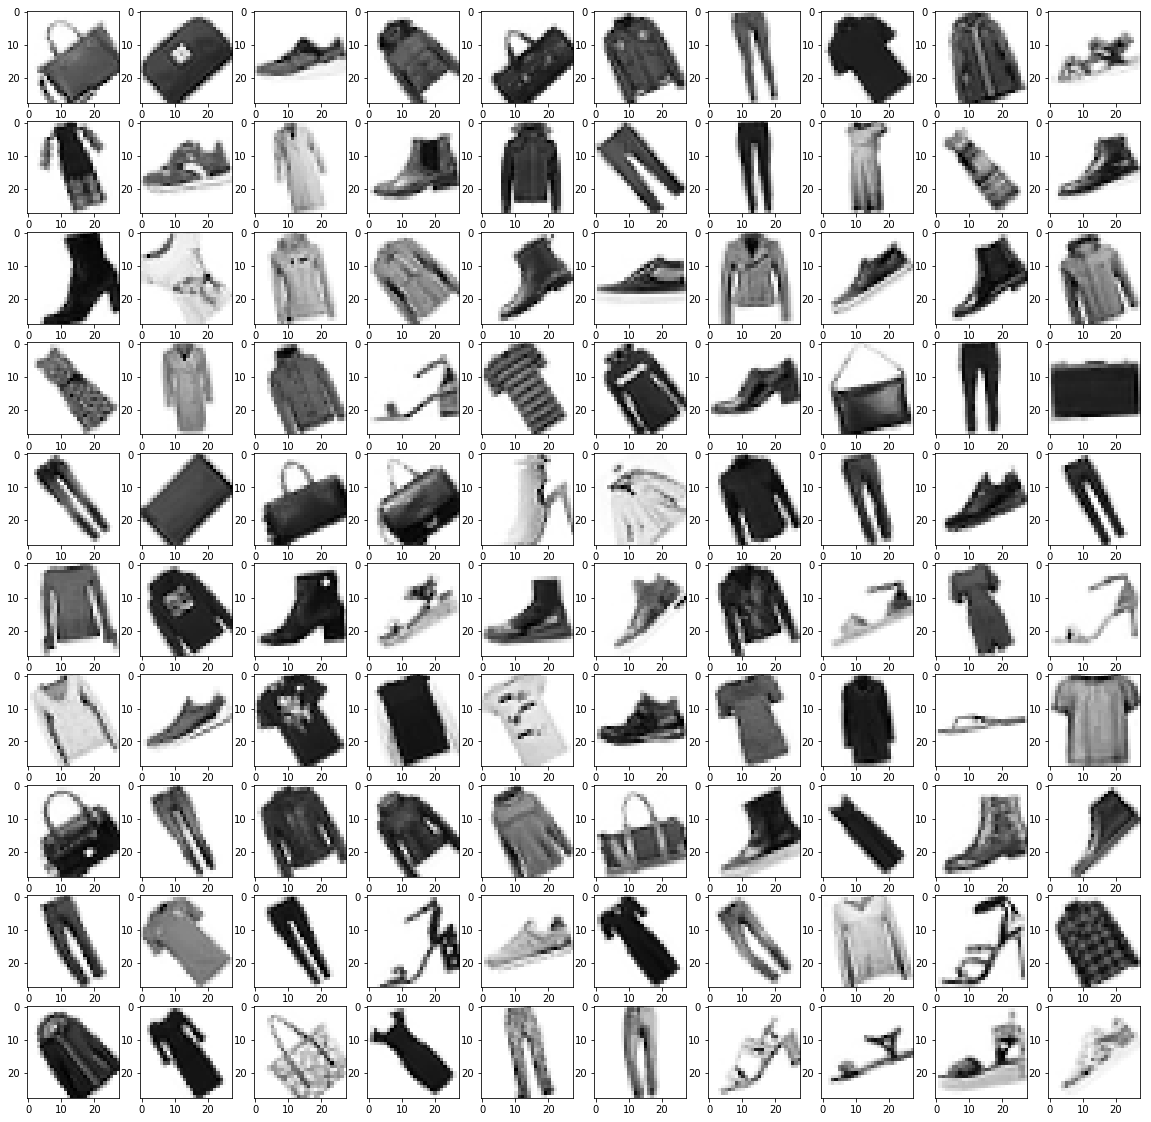

In [3]:
img_np2 = np.load("train_images_rotated.npy", mmap_mode=None, allow_pickle=True, fix_imports=True)

fig=plt.figure(figsize=(20, 20))
columns = 10
rows = 10
image_index = 0
for i in range(1, columns*rows +1):
    img = img_np2[image_index]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="Greys")
    image_index = image_index + 1
    
plt.show()

### 1.3 Exploração do dataset de imagens ruidosas

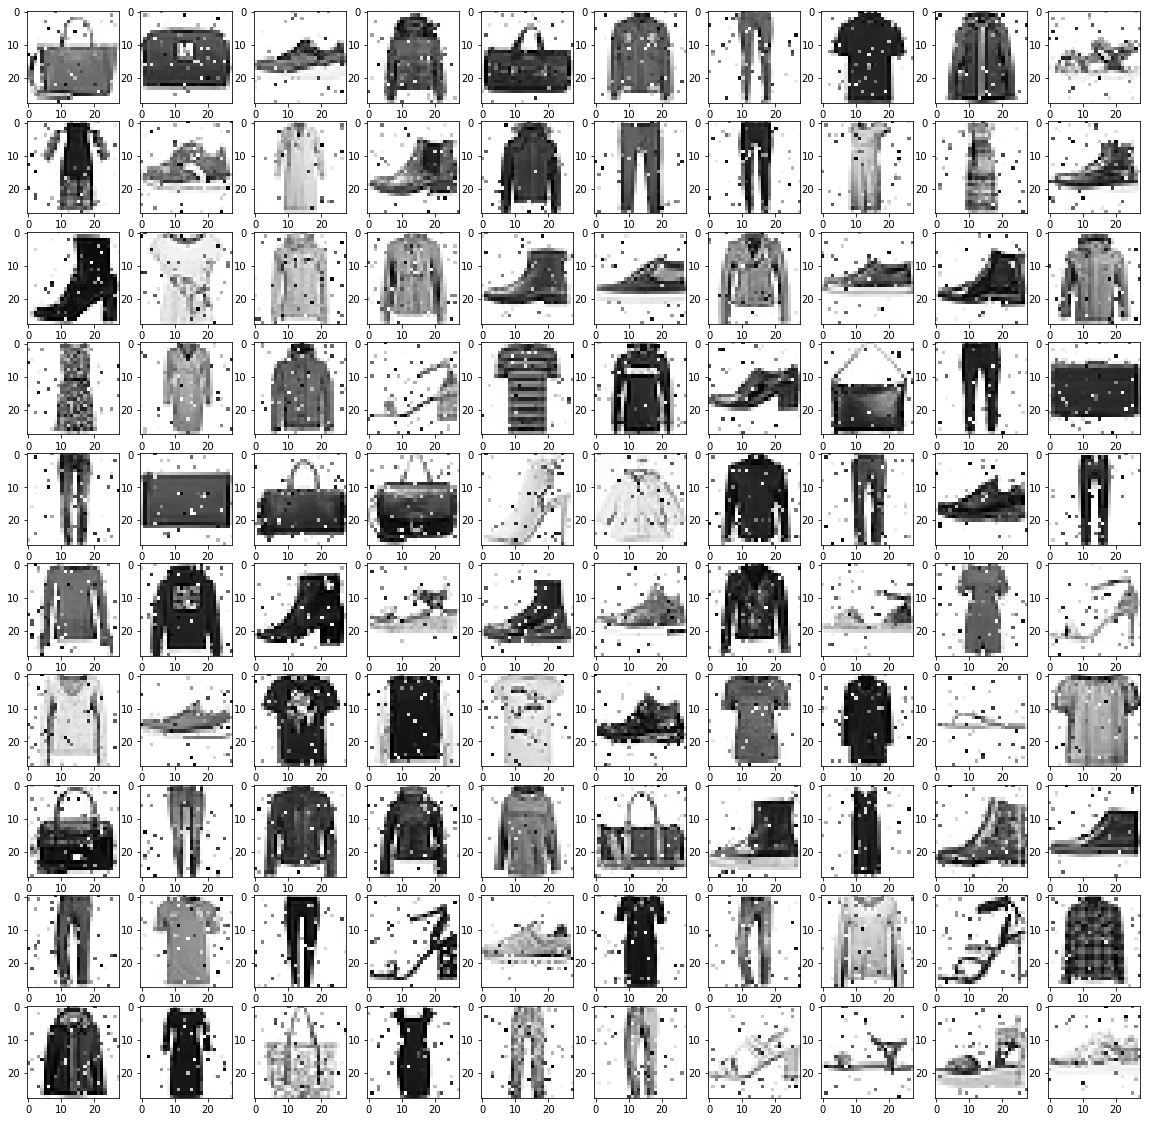

In [4]:
img_np3 = np.load("train_images_noisy.npy", mmap_mode=None, allow_pickle=True, fix_imports=True)

fig=plt.figure(figsize=(20, 20))
columns = 10
rows = 10
image_index = 0
for i in range(1, columns*rows +1):
    img = img_np3[image_index]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="Greys")
    image_index = image_index + 1
    
plt.show()

### 1.4 Exploração do dataset de imagens rotacionadas e ruidosas

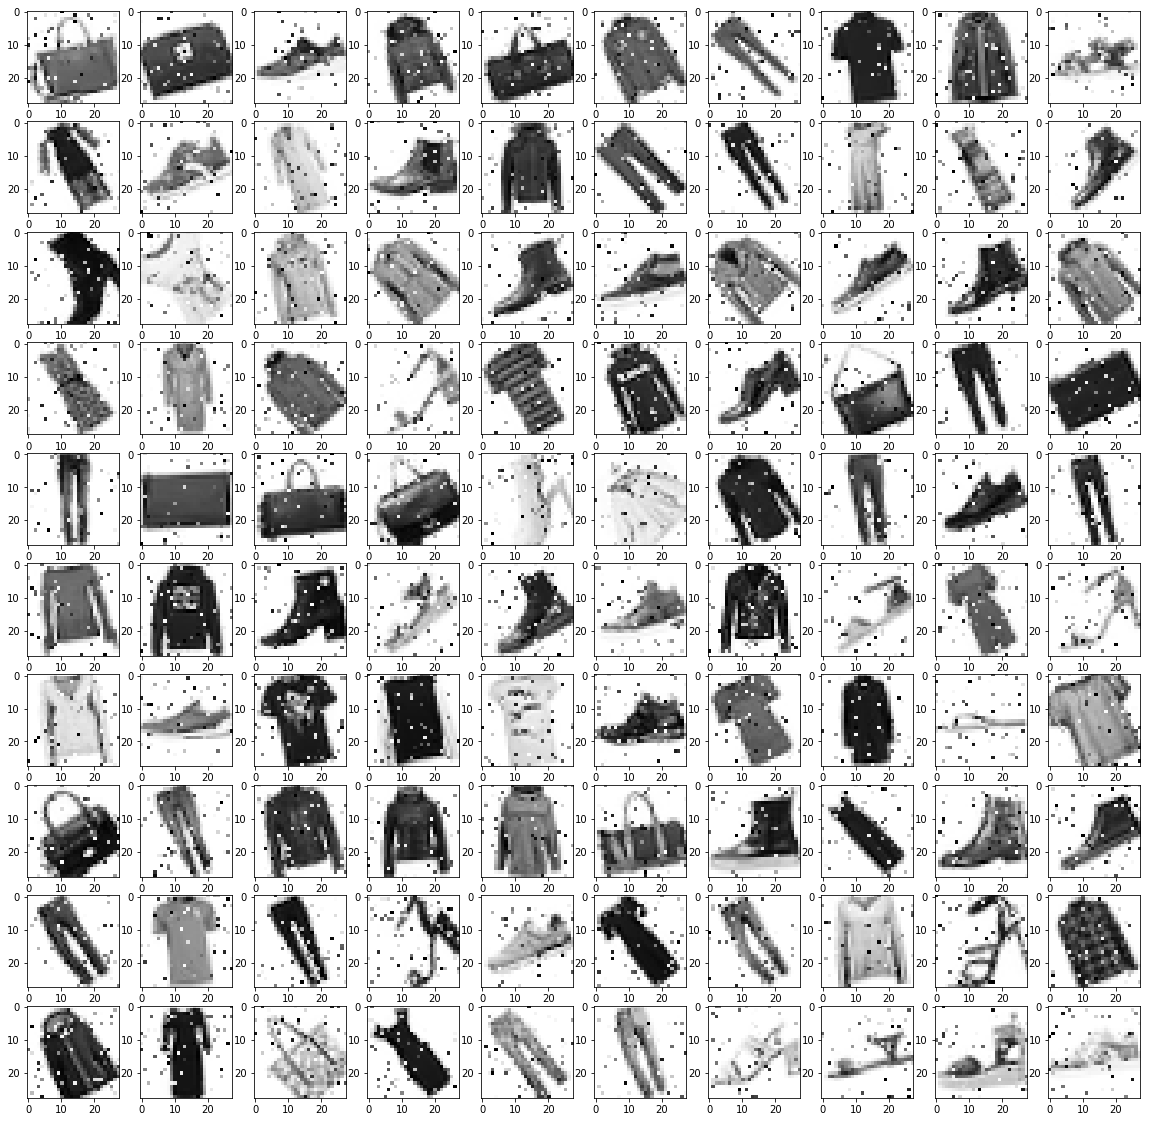

In [5]:
img_np4 = np.load("train_images_both.npy", mmap_mode=None, allow_pickle=True, fix_imports=True)

fig=plt.figure(figsize=(20, 20))
columns = 10
rows = 10
image_index = 0
for i in range(1, columns*rows +1):
    img = img_np4[image_index]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="Greys")
    image_index = image_index + 1
    
plt.show()

### 1.5 Conclusão sobre a base de dados de treino fornecida

**(1)** Trata-se de uma base de dados que impõe múltiplas condições no treino. A diferença entre elas basicamente é que a primeira é "pura", ou seja, não está rotacionada e nem tem pixels ruidosos. A segunda as peças de roupa foram apenas rotacionadas, enquanto que na terceira apenas vítimas de pixels ruidosos. Por fim, a última base de dados impõe pixels ruidosos e rotação nas peças de roupas.

In [6]:
test = np.load("Test_images.npy", mmap_mode=None, allow_pickle=True, fix_imports=True)


## 2. Implementação de Rede Neural Convolucional de Classificação sem usar Pooling

- As Redes Neurais Convolucionais são amplamente usadas para resolver problemas de visão computacional. Assim, cada pixel das imagens deverá ser entendido como uma feature. Dessa forma, cada pixel da imagem será um input da Rede Neural Convolucional (ou seja, cada pixel "entra" em um neurônio da primeira camada).


- Convolução em RNC significa, basicamente, pegar 2 imagens e gerar uma terceira imagem a partir das duas. É basicamente uma composição de dadas duas funções. Então você dá uma imagem como Input e terá outra imagem para realizar a convolução. Essa outra imagem será o Kernel da convolução. O resultado após a aplicação do operador convolução sobre as imagens resultará em um tensor que medirá as regiões em que as duas imagens são similares. Ou seja: onde o kernel mais aparece na imagem passada como input. Trata-se, então, de uma operação dentro da rede responsável por identificar padrões. Os valores dos pixels do kernel serão os pesos que conectarão os neurônios (pixels da imagem de input) com os novos neurônios (pixels da imagem de convolução) [min. 25:00 video]. O Kernel deve ser aprendido pelo modelo, para aplicar a melhor convolução sobre uma imagem.


- Quanto mais operações de convolução tiverem na rede, mais detalhada será nossa busca por padrões.

### 2.1 Carregando e configurando os dados

In [7]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import pandas as pd
K.set_image_dim_ordering('th')

# Carregando dados de treino da base rotacionada

x_train_rotated = np.load("train_images_rotated.npy", mmap_mode=None, allow_pickle=True, fix_imports=True)

# Carregando dados de treino da base both

x_train_both = np.load("train_images_both.npy", mmap_mode=None, allow_pickle=True, fix_imports=True)

# Carregando dados dos labels

y_train = pd.read_csv('train_labels.csv')
y_train = np.array(y_train.drop(['Id'], axis=1))

# Carreando dados de teste

x_test = np.load("Test_images.npy", mmap_mode=None, allow_pickle=True, fix_imports=True)

# imagens podem ter várias camadas de cor - R,G,B, por exemplo. Assim sendo, modelos convolucionais geralmente esperam
# em suas entradas, matrizes tetradimensionais, i.e., no formato [samples][canais][width][height] , onde canais é o número
# de canais de cor de sua imagem. No caso do MNIST, é uma imagem em grayscale, então temos apenas um canal de cor. 

x_train_rotated = x_train_rotated.reshape(x_train_rotated.shape[0], 1, 28, 28).astype('float32')
x_train_both = x_train_both.reshape(x_train_both.shape[0], 1, 28, 28).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28).astype('float32')

## NORMALIZAR OS DADOS PARA MELHORAR O DESEMPENHO DA CONVOLUÇÃO
x_train_rotated = x_train_rotated / 255
x_train_both = x_train_both / 255
x_test = x_test / 255

# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
num_classes = y_train.shape[1]
print("Numero de classes: %d " % num_classes)

# separando o treinamento entre treino e validação: 
x_real_train_rotated, x_validation_rotated, y_real_train_rotated, y_validation_rotated = train_test_split(x_train_rotated, y_train, test_size = 0.2)
x_real_train_both, x_validation_both, y_real_train_both, y_validation_both = train_test_split(x_train_both, y_train, test_size = 0.2)

Using TensorFlow backend.


Numero de classes: 10 


### 2.2 Construindo a Rede Neural Convolucional sem Pooling

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 24, 24)        780       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 20, 20)        11265     
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 20, 20)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               768128    
_________________________________________________________________
dense_2 (Dense)              (None, 50)                6450      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
Total para

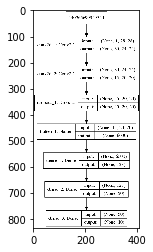

In [8]:
rnc1_model = Sequential()

rnc1_model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu'))

rnc1_model.add(Conv2D(15, (5, 5), activation='relu'))

rnc1_model.add(Dropout(0.2))

rnc1_model.add(Flatten())

rnc1_model.add(Dense(128, activation='relu'))

rnc1_model.add(Dense(50, activation='relu'))

rnc1_model.add(Dense(num_classes, activation='softmax'))

# Compile model
rnc1_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
rnc1_model.summary()

# Visualizing the model
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plot_model(rnc1_model, show_shapes=True, show_layer_names=True, to_file="cnn1.png")
img = mpimg.imread('cnn1.png')
plt.imshow(img)

### 2.3 Ajustando os dois modelos: treino com base rotacionada e treino com base both.

In [9]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2)]

# Fit the model do treino ROTACIONADO
rnc1_model.fit(x_real_train_rotated, y_real_train_rotated, validation_data=(x_validation_rotated,y_validation_rotated), epochs=2, 
          batch_size=200, verbose=1, callbacks = callbacks)

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 285s 6ms/step - loss: 0.7038 - acc: 0.7428 - val_loss: 0.5238 - val_acc: 0.8025
Epoch 2/2
48000/48000 [==============================] - 286s 6ms/step - loss: 0.4825 - acc: 0.8221 - val_loss: 0.4572 - val_acc: 0.8280


In [10]:
# Fit the model do treino BOTH

rnc1_model.fit(x_real_train_both, y_real_train_both, validation_data=(x_validation_both,y_validation_both), epochs=2, 
          batch_size=200, verbose=1, callbacks = callbacks)

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 237s 5ms/step - loss: 0.4556 - acc: 0.8316 - val_loss: 0.4607 - val_acc: 0.8262
Epoch 2/2
48000/48000 [==============================] - 306s 6ms/step - loss: 0.4048 - acc: 0.8500 - val_loss: 0.3993 - val_acc: 0.8549


Por fim, notamos que o modelo (sem MaxPooling) se comportou da seguinte maneira:

- Para o modelo treinado com a base rotacionada, a acurácia calculada no segundo Epoch foi de 0.8134;
- Para o modelo treinado com a base rotacionada e poluída, a acurácia calculada no segundo Epoch foi de 0.8563;

## 3. Implementação de Rede Neural Convolucional de Classificação usando camadas de Pooling

- O que é o Pooling? [+/- min 42 video] Trata-se de uma camada que torna nossa rede mais resistente (menos sensíveis) às mudanças da imagem. Pensando somente na rede sem Pooling, sabemos que qualquer mudançazinha na imagem pode fazer com que o Kernel não seja tão útil na detecção de padrões, durante a convolução. Assim, o Pooling vai atuar na convolução, tratando de pegar valores mais significantes da operação de convolução. Ou seja, pequenas variações na imagem de input não serão suficiente para alterar os valores da camada de Pooling, pois ela lida apenas com informações mais "significantes". O mais comum é o Max Pooling.

### 3.1 Construindo a Arquitetura da Rede Neural Convolucional com Max Pooling

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 24, 24)        780       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 12, 12)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 8, 8)          11265     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 4, 4)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 4, 4)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 240)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               30848     
__________

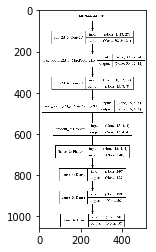

In [11]:
rnc2_model = Sequential()

rnc2_model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu'))
rnc2_model.add(MaxPooling2D(pool_size=(2, 2)))

rnc2_model.add(Conv2D(15, (5, 5), activation='relu'))
rnc2_model.add(MaxPooling2D(pool_size=(2, 2)))

rnc2_model.add(Dropout(0.2))

rnc2_model.add(Flatten())

rnc2_model.add(Dense(128, activation='relu'))

rnc2_model.add(Dense(50, activation='relu'))

rnc2_model.add(Dense(num_classes, activation='softmax'))

# Compile model
rnc2_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
rnc2_model.summary()

# Visualizing the model
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plot_model(rnc2_model, show_shapes=True, show_layer_names=True, to_file="cnn2.png")
img = mpimg.imread('cnn2.png')
plt.imshow(img)

### 3.2 Treinando a Rede Neural Convolucional com base rotacionada e base roth

In [12]:
# Fit the model do treino ROTACIONADO
rnc2_model.fit(x_real_train_rotated, y_real_train_rotated, validation_data=(x_validation_rotated,y_validation_rotated), epochs=2, 
          batch_size=200, verbose=1, callbacks = callbacks)

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 259s 5ms/step - loss: 0.9367 - acc: 0.6548 - val_loss: 0.6351 - val_acc: 0.7644
Epoch 2/2
48000/48000 [==============================] - 209s 4ms/step - loss: 0.6226 - acc: 0.7679 - val_loss: 0.5425 - val_acc: 0.7989


In [13]:
# Fit the model do treino BOTH

rnc2_model.fit(x_real_train_both, y_real_train_both, validation_data=(x_validation_both,y_validation_both), epochs=2, 
          batch_size=200, verbose=1, callbacks = callbacks)

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 128s 3ms/step - loss: 0.5848 - acc: 0.7819 - val_loss: 0.5047 - val_acc: 0.8175
Epoch 2/2
48000/48000 [==============================] - 127s 3ms/step - loss: 0.5351 - acc: 0.7985 - val_loss: 0.4683 - val_acc: 0.8295


Por fim, notamos que o modelo (com MaxPooling) se comportou da seguinte maneira:

- Para o modelo treinado com a base rotacionada, a acurácia calculada no segundo Epoch foi de 0.7784;
- Para o modelo treinado com a base rotacionada e poluída, a acurácia calculada no segundo Epoch foi de 0.8143;

Dessa forma, observamos valores menores de acurácia para a Rede Neural Convolucional construída com o MaxPooling. Uma hipótese para o ocorrido poderia ser que com as camadas de MaxPooling, a operação de convolução é realizada utilizando-se menos parâmetros provenientes da base de treino para o aprendizado da rede. No caso do MaxPooling, a imagem convolucionada é formada apenas com os pixels de maior valor de cada operação com o Kernel. No entanto, acredito que a utilização de MaxPooling gera modelos menos decoreba e mais generalizados, pois a Rede Neural Convolucional se torna mais resistente às mudanças na base de treino.

## 4. Um possível pré-processamento das Imagens

A partir da sugestão de leitura, notei que é possível realizar um pré-processamento de imagens visando à diminiuição do *noise*, ruído. A técnica descrita em [7] consiste em: 

    "Gaussian blur (also known as Gaussian smoothing) is the result of blurring an image by a Gaussian function. It is a widely used effect in graphics software, typically to reduce image noise. The visual effect of this blurring technique is a smooth blur resembling that of viewing the image through a translucent screen, distinctly different from the bokeh effect produced by an out-of-focus lens or the shadow of an object under usual illumination. Gaussian smoothing is also used as a pre-processing stage in computer vision algorithms in order to enhance image structures at different scales."

Em suma, trata-se de borrar a imagem utilizando a Função de Gauss.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

## carregar dados da base de treino noisy

x_train_noisy = np.load("train_images_noisy.npy", mmap_mode=None, allow_pickle=True, fix_imports=True)

In [19]:
import cv2 #Importar OpenCV para processar imagem

# Remove noise
# Gaussian

no_noise = []

for i in range(len(x_train_noisy)):
    blur = cv2.GaussianBlur(x_train_noisy[i], (5, 5), 0)
    no_noise.append(blur)

x_train_no_noisy = no_noise

x_train_no_noisy = np.array(x_train_no_noisy)

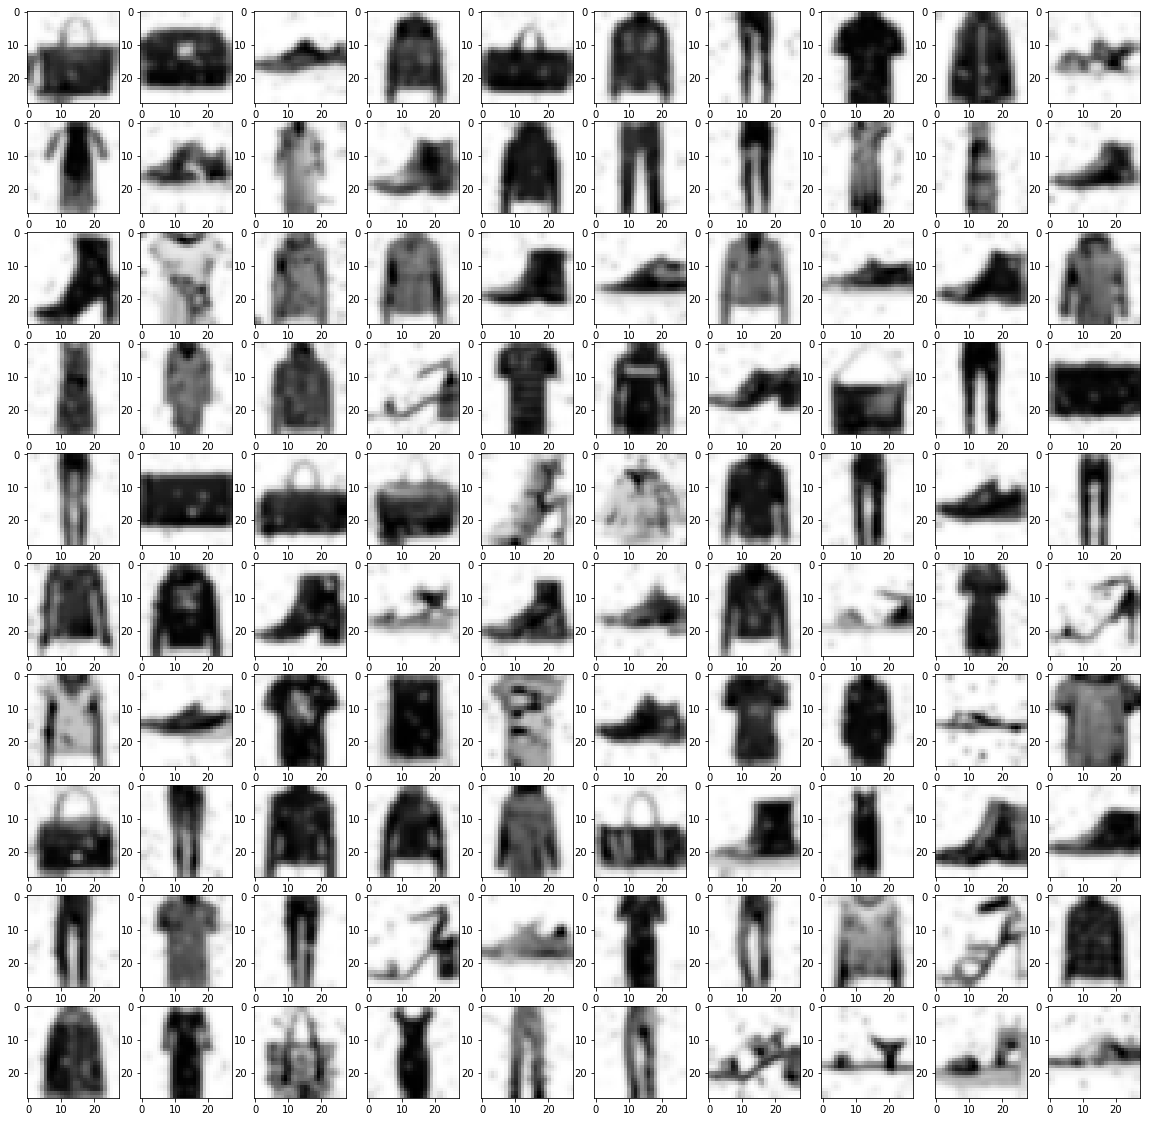

In [20]:
## Mostrar a base de dados borradas "Gaussianamente"

fig=plt.figure(figsize=(20, 20))
columns = 10
rows = 10
image_index = 0
for i in range(1, columns*rows +1):
    img = x_train_no_noisy[image_index]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="Greys")
    image_index = image_index + 1
    
plt.show()

Uau! Nossa base de dados foi borrada com sucesso... Já dá pra ver uma boa diferença da ruidosa (em 1.3)! Agora vamos ver como será o treinamento...

In [24]:
# Reformando os dados

x_train_no_noisy = x_train_no_noisy.reshape(x_train_no_noisy.shape[0], 1, 28, 28).astype('float32')

x_train_noisy = x_train_noisy.reshape(x_train_noisy.shape[0], 1, 28, 28).astype('float32')

# Normalizando os dados

x_train_no_noisy = x_train_no_noisy / 255

x_train_noisy = x_train_noisy / 255

# Separando o treinamento entre treino e validação: 

x_real_train_no_noisy, x_validation_no_noisy, y_real_train_no_noisy, y_validation_no_noisy = train_test_split(x_train_no_noisy, y_train, test_size = 0.2)

x_real_train_noisy, x_validation_noisy, y_real_train_noisy, y_validation_noisy = train_test_split(x_train_noisy, y_train, test_size = 0.2)


In [22]:
# Fit the model do treino BORRADO
rnc1_model.fit(x_real_train_no_noisy, y_real_train_no_noisy, validation_data=(x_validation_no_noisy, y_validation_no_noisy), epochs=2, 
          batch_size=200, verbose=1, callbacks = callbacks)

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 235s 5ms/step - loss: 0.3834 - acc: 0.8588 - val_loss: 0.3349 - val_acc: 0.8792
Epoch 2/2
48000/48000 [==============================] - 238s 5ms/step - loss: 0.3132 - acc: 0.8850 - val_loss: 0.3070 - val_acc: 0.8886


In [25]:
# Fit the model do treino RUIDOSO
rnc1_model.fit(x_real_train_noisy, y_real_train_noisy, validation_data=(x_validation_noisy,y_validation_noisy), epochs=2, 
          batch_size=200, verbose=1, callbacks = callbacks)

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 236s 5ms/step - loss: 1.4700 - acc: 0.4661 - val_loss: 0.7375 - val_acc: 0.7193
Epoch 2/2
48000/48000 [==============================] - 282s 6ms/step - loss: 0.7002 - acc: 0.7345 - val_loss: 0.6425 - val_acc: 0.7590


Assim, notamos a seguinte diferença entre os treinos com a borrada e a ruidosa: a base borrada deu acurácia de 88.9% no segundo Epoch enquanto a ruidosa deu 76%. Ou seja, o pré-processamento da imagem pelo método do Blur Gaussian auxiliou e muito na melhoria da acurácia de treino.

## 5. Single Pixel Attack

De acordo com [8], um *Single Pixel Attack* pode ser compreendido como uma Rede Neural Profunda que pode ser facilmente alterada por pequenas perturbações, nesse caso, a modificação de apenas um pixel na imagem. Trata-se de uma problemática importante pois, segundo o artigo [8]:

    "The results show that 68.36% of the natural images in CIFAR-
    10 test dataset and 41.22% of the ImageNet (ILSVRC 2012)
    validation images can be perturbed to at least one target
    class by modifying just one pixel with 73.22% and 5.52%
    confidence on average. Thus, the proposed attack explores
    a different take on adversarial machine learning in an ex-
    treme limited scenario, showing that current DNNs are also
    vulnerable to such low dimension attacks."
    
Uma técnica para lidar com esse problema é um método baseado em *differential evolution*. Essa técnica consiste em realizar uma série de mudanças aleatórias na imagem, checando como cada uma dessas mudanças realizadas diminui o intervalo de confiança das classes que não temos interesse que a Rede atue (classifique). Assim, o algoritmo de *differential evolution* filtra as mudanças que provocaram alterações negativas e continua procurando por mudanças mais positivas em relação à classe que temos interesse.
 

## Referências:

- [1] How display multiple images (second comment): https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645


- [2] Deep Learning - Redes Neurais Convolucionais: https://www.youtube.com/watch?v=DXnyuUZcAAI


- [3] Convolutional Neural Networks - Deep Learning basics with Python, TensorFlow and Keras p.3:
https://www.youtube.com/watch?v=WvoLTXIjBYU&list=PLQVvvaa0QuDfhTox0AjmQ6tvTgMBZBEXN&index=3


- [4] What is the meaning of flattening step in a convolutional neural network?: https://www.quora.com/What-is-the-meaning-of-flattening-step-in-a-convolutional-neural-network 


- [5] Tutorial de Keras. Notas de aula da disciplina PMR 3508 Aprendizado de Máquinas e Reconhecimento de Padrões.


- [6] Convolutional Layers: https://keras.io/layers/convolutional/


- [7] Image Pre-processing: https://towardsdatascience.com/image-pre-processing-c1aec0be3edf


- [8] One pixel attack for fooling deep neural networks. Disponível em: https://arxiv.org/abs/1710.08864
